In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd //content/drive/MyDrive/Helmet_Detection/yolov10

/content/drive/MyDrive/Helmet_Detection/yolov10


In [5]:
!nvidia-smi

Sun Jul  7 08:22:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
import os
HOME = os.getcwd()
print(HOME)

/content/drive/MyDrive/Helmet_Detection/yolov10


## Download pre-trained weights

**NOTE:** YOLOv10 provides weight files pre-trained on the COCO dataset in various sizes. Let's download them.

In [ ]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

total 408M
-rw-r--r-- 1 root root  80M May 26 15:53 yolov10b.pt
-rw-r--r-- 1 root root 100M May 26 15:53 yolov10l.pt
-rw-r--r-- 1 root root  64M May 26 15:54 yolov10m.pt
-rw-r--r-- 1 root root  11M May 26 15:54 yolov10n.pt
-rw-r--r-- 1 root root  32M May 26 15:54 yolov10s.pt
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt


## Download dataset

In [ ]:
!gdown '1tr9PSRRdlC2pNir7jsYugpSMG-7v32VJ' -O './images/'

Downloading...
From: https://drive.google.com/uc?id=1tr9PSRRdlC2pNir7jsYugpSMG-7v32VJ
To: /content/drive/MyDrive/Helmet_Detection/yolov10/images/HCMC_Street.jpg
100% 374k/374k [00:00<00:00, 90.2MB/s]


## Testing pretrained model

In [7]:
from ultralytics import YOLOv10

MODEL_PATH = 'pretrained_model/weights/yolov10n.pt'
model = YOLOv10(MODEL_PATH)

In [8]:
IMG_PATH = 'images/HCMC_Street.jpg'
result = model(source = IMG_PATH)[0]


image 1/1 /content/drive/MyDrive/Helmet_Detection/yolov10/images/HCMC_Street.jpg: 448x640 11 persons, 2 bicycles, 1 car, 2 motorcycles, 63.9ms
Speed: 17.0ms preprocess, 63.9ms inference, 4.3ms postprocess per image at shape (1, 3, 448, 640)


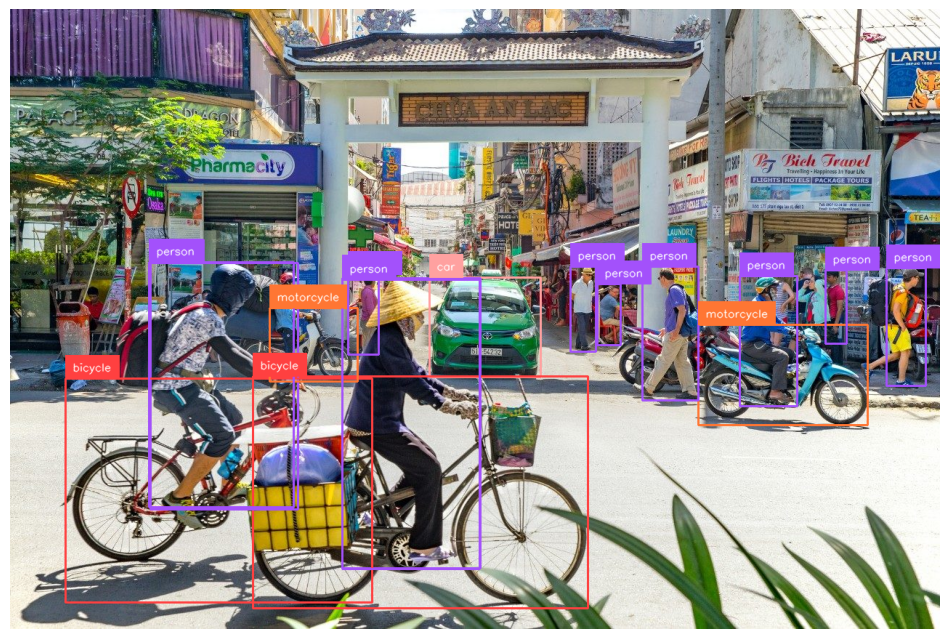

In [9]:
import cv2
import supervision as sv

detections = sv.Detections.from_ultralytics(result)
image = cv2.imread(IMG_PATH)
bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [ ]:
result.save('./images/HCMC_Street_predict.png')

'./images/HCMC_Street_predict.png'

In [ ]:
! gdown '1twdtZEfcw4ghSZIiPDypJurZnNXzMO7R'

Downloading...
From (original): https://drive.google.com/uc?id=1twdtZEfcw4ghSZIiPDypJurZnNXzMO7R
From (redirected): https://drive.google.com/uc?id=1twdtZEfcw4ghSZIiPDypJurZnNXzMO7R&confirm=t&uuid=1925140c-81e5-40cf-8130-1ba67cc7a779
To: /content/drive/MyDrive/Helmet_Detection/yolov10/Safety_Helmet_Dataset.zip
100% 33.7M/33.7M [00:01<00:00, 17.6MB/s]


In [ ]:
! mkdir safety_helmet_dataset

mkdir: cannot create directory ‘safety_helmet_dataset’: File exists


In [ ]:
! unzip -q '/content/drive/MyDrive/Helmet_Detection/yolov10/Safety_Helmet_Dataset.zip' -d '/content/drive/MyDrive/Helmet_Detection/yolov10/safety_helmet_dataset'

replace /content/drive/MyDrive/Helmet_Detection/yolov10/safety_helmet_dataset/README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Train new model

In [11]:
from ultralytics import YOLOv10

MODEL_PATH = 'pretrained_model/weights/yolov10n.pt'
model = YOLOv10(MODEL_PATH)

In [12]:
model.info()

YOLOv10n summary: 385 layers, 2775520 parameters, 2775504 gradients


(385, 2775520, 2775504, 0.0)

In [14]:
YAML_PATH = '/content/drive/MyDrive/Helmet_Detection/yolov10/safety_helmet_dataset/data.yaml'
EPOCHS = 25
IMG_SIZE = 640
BATCH_SIZE = 16

model.train(data = YAML_PATH,
            epochs = EPOCHS,
            batch = BATCH_SIZE,
            imgsz = IMG_SIZE)

New https://pypi.org/project/ultralytics/8.2.50 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.0.1+cu117 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=pretrained_model/weights/yolov10n.pt, data=/content/drive/MyDrive/Helmet_Detection/yolov10/safety_helmet_dataset/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augme

100%|██████████| 755k/755k [00:00<00:00, 20.1MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

train: Scanning /content/drive/MyDrive/Helmet_Detection/yolov10/safety_helmet_dataset/train/labels... 761 images, 0 backgrounds, 0 corrupt: 100%|██████████| 761/761 [05:42<00:00,  2.22it/s]


train: New cache created: /content/drive/MyDrive/Helmet_Detection/yolov10/safety_helmet_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Helmet_Detection/yolov10/safety_helmet_dataset/valid/labels... 218 images, 0 backgrounds, 0 corrupt: 100%|██████████| 218/218 [01:35<00:00,  2.28it/s]

val: New cache created: /content/drive/MyDrive/Helmet_Detection/yolov10/safety_helmet_dataset/valid/labels.cache


Plotting labels to /content/drive/MyDrive/Helmet_Detection/yolov10/runs/detect/train10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Helmet_Detection/yolov10/runs/detect/train10
Starting training for 25 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       1/25      0.43G      1.652      2.546      1.651      1.458      4.577      1.485         25        640: 100%|██████████| 48/48 [00:31<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]

                   all        218        586    0.00828      0.643       0.17      0.081



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       2/25      3.18G      1.694      1.888      1.626      1.516      3.935      1.499         50        640: 100%|██████████| 48/48 [00:21<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]

                   all        218        586      0.657      0.169      0.218      0.087



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       3/25      3.18G      1.689      1.769      1.605      1.578      3.354      1.518         53        640: 100%|██████████| 48/48 [00:22<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


                   all        218        586      0.602      0.278      0.263     0.0997

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       4/25      3.18G      1.696      1.731      1.613      1.626      3.053      1.565         31        640: 100%|██████████| 48/48 [00:21<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        218        586      0.623      0.384      0.357      0.166



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       5/25      3.21G      1.691       1.67      1.601      1.619      2.713      1.533         35        640: 100%|██████████| 48/48 [00:22<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]

                   all        218        586      0.587      0.314      0.268      0.108



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       6/25       3.2G      1.666      1.609      1.563      1.606      2.465      1.483         33        640: 100%|██████████| 48/48 [00:22<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]

                   all        218        586      0.642      0.396      0.367      0.156



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       7/25      3.19G       1.66      1.524      1.553      1.627      2.193      1.478         46        640: 100%|██████████| 48/48 [00:21<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

                   all        218        586      0.729       0.42      0.477      0.217



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       8/25      3.18G      1.617      1.487      1.536      1.585      2.098      1.475         62        640: 100%|██████████| 48/48 [00:20<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]

                   all        218        586      0.577      0.481      0.521      0.248



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       9/25       3.2G      1.632      1.423      1.538      1.607      1.935      1.472         44        640: 100%|██████████| 48/48 [00:22<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        218        586      0.797      0.436      0.565      0.261



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      10/25      3.18G      1.619      1.397      1.538      1.597      1.835      1.476         49        640: 100%|██████████| 48/48 [00:21<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]

                   all        218        586      0.605      0.502       0.57       0.27



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      11/25      3.18G       1.59      1.321      1.503      1.583      1.714      1.453         45        640: 100%|██████████| 48/48 [00:22<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]

                   all        218        586      0.746      0.521      0.618      0.291



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      12/25      3.18G      1.556      1.304      1.492      1.546      1.677      1.442         37        640: 100%|██████████| 48/48 [00:21<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]

                   all        218        586      0.643      0.595      0.634      0.291



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      13/25      3.18G      1.549      1.266      1.492      1.546      1.601      1.434         56        640: 100%|██████████| 48/48 [00:21<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


                   all        218        586      0.596      0.647      0.647      0.316

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      14/25      3.18G      1.531       1.22      1.468      1.536      1.525      1.416         39        640: 100%|██████████| 48/48 [00:22<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]

                   all        218        586      0.547      0.667      0.662      0.324



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      15/25      3.14G      1.521      1.188      1.451      1.533      1.457      1.411         41        640: 100%|██████████| 48/48 [00:21<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.33it/s]

                   all        218        586      0.782      0.559      0.663      0.326


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      16/25      3.37G      1.485      1.089      1.502      1.506      1.306      1.482         26        640: 100%|██████████| 48/48 [00:23<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


                   all        218        586      0.689      0.651      0.723      0.359

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      17/25      3.16G      1.502      1.009      1.499      1.512      1.205      1.472         32        640: 100%|██████████| 48/48 [00:20<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        218        586       0.71      0.673      0.732      0.365



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      18/25      3.16G      1.461      0.985      1.472      1.485       1.17      1.444         20        640: 100%|██████████| 48/48 [00:20<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        218        586      0.813      0.628      0.761      0.381



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      19/25      3.16G      1.435     0.9362      1.461       1.47      1.092      1.444         30        640: 100%|██████████| 48/48 [00:20<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

                   all        218        586      0.691      0.726      0.768      0.386



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      20/25      3.16G      1.416     0.9177      1.445       1.45      1.066      1.421         19        640: 100%|██████████| 48/48 [00:20<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

                   all        218        586      0.715      0.709       0.75      0.376



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      21/25      3.16G      1.399     0.8884      1.427      1.416      1.018      1.397         31        640: 100%|██████████| 48/48 [00:20<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]

                   all        218        586      0.707      0.715      0.763      0.385



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      22/25      3.18G       1.37     0.8567      1.404       1.39     0.9852      1.373         21        640: 100%|██████████| 48/48 [00:20<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]

                   all        218        586       0.77      0.725      0.784      0.413



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      23/25      3.16G      1.332     0.8207      1.379      1.359     0.9444       1.36         29        640: 100%|██████████| 48/48 [00:21<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]

                   all        218        586      0.799      0.699      0.791      0.402



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      24/25      3.16G      1.316     0.8096      1.374      1.341     0.9289      1.349         21        640: 100%|██████████| 48/48 [00:20<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

                   all        218        586      0.793      0.706      0.792      0.415



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      25/25      3.17G      1.287     0.7714      1.349      1.312     0.8996      1.334         32        640: 100%|██████████| 48/48 [00:21<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]

                   all        218        586      0.676      0.771      0.786      0.414



25 epochs completed in 0.203 hours.
Optimizer stripped from /content/drive/MyDrive/Helmet_Detection/yolov10/runs/detect/train10/weights/last.pt, 5.8MB
Optimizer stripped from /content/drive/MyDrive/Helmet_Detection/yolov10/runs/detect/train10/weights/best.pt, 5.8MB

Validating /content/drive/MyDrive/Helmet_Detection/yolov10/runs/detect/train10/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.0.1+cu117 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2695586 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


                   all        218        586      0.792      0.706      0.792      0.415
                  head        218         27      0.756      0.481      0.613      0.311
                helmet        218        285      0.834      0.839      0.917      0.457
                person        218        274      0.788      0.798      0.846      0.477
Speed: 6.8ms preprocess, 5.7ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /content/drive/MyDrive/Helmet_Detection/yolov10/runs/detect/train10


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78d3ac699570>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

## Testing new model



In [16]:
TRAINED_MODEL_PATH = 'runs/detect/train10/weights/best.pt'
model = YOLOv10(TRAINED_MODEL_PATH)

model.val(data = YAML_PATH, imgsz = IMG_SIZE, split ='test')

Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.0.1+cu117 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2695586 parameters, 0 gradients


val: Scanning /content/drive/MyDrive/Helmet_Detection/yolov10/safety_helmet_dataset/test/labels... 109 images, 0 backgrounds, 0 corrupt: 100%|██████████| 109/109 [00:46<00:00,  2.33it/s]

val: New cache created: /content/drive/MyDrive/Helmet_Detection/yolov10/safety_helmet_dataset/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


                   all        109        320      0.568      0.721      0.737      0.379
                  head        109         16      0.504      0.438      0.595      0.256
                helmet        109        162        0.6      0.901      0.878       0.44
                person        109        142      0.599      0.824      0.739      0.439
Speed: 7.0ms preprocess, 37.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /content/drive/MyDrive/Helmet_Detection/yolov10/runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78d3adc2b460>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

## Download dataset from Roboflow Universe

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install -q roboflow

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')

rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("selencakmak").project("tumor-dj2a1")
version = project.version(1)
dataset = version.download("yolov8")

**NOTE:**
Make sure the last 4 lines of the data.yaml file have the following format:

```
test: ../test/images
train: ../train/images
val: ../valid/images
```

If using a dataset from Roboflow Universe, run the command below. 👇🏻

In [ ]:
# !sed -i '$d' {dataset.location}/data.yaml
# !sed -i '$d' {dataset.location}/data.yaml
# !sed -i '$d' {dataset.location}/data.yaml
# !sed -i '$d' {dataset.location}/data.yaml
# !echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

## Custom Training

In [ ]:
%cd {HOME}

!yolo task=detect mode=train epochs=10 batch=32 plots=True \
model={HOME}/weights/yolov10n.pt \
data={dataset.location}/data.yaml

In [ ]:
!ls {HOME}/runs/detect/train/

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

## Inference with Custom Model

**NOTE:** Let's start by loading our newly trained model.

In [ ]:
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/runs/detect/train/weights/best.pt')

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/valid/images",
    annotations_directory_path=f"{dataset.location}/valid/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

**NOTE:** Let's randomly select an image from our validation set and visualize the results.

In [ ]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)